In [177]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt

In [178]:
dataType='val2017'
annFile=f'dataset/annotations/instances_{dataType}.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [7]:
catNms = ['airplane', 'cat', 'dog']
catIds = coco.getCatIds(catNms=catNms)
cat_dict = dict(zip(catIds,catNms))

In [16]:
cat_ids = {}
x_id = []
Y = []
total = 0
for cat in catIds:
  cat_ids[cat_dict[cat]] = coco.getImgIds(catIds=cat)
  for img_id in cat_ids[cat_dict[cat]]:
        x_id.append(img_id)
        Y.append(cat_dict[cat])
  print(cat_dict[cat], len(cat_ids[cat_dict[cat]]))
  total += len(cat_ids[cat_dict[cat]])
print(f'\ntotal = {len(catIds)}\ntotal no. of imgs = {total}')

airplane 97
cat 184
dog 177

total = 3
total no. of imgs = 458


In [64]:
from skimage.transform import resize as imresize
import skimage.io as io
import os

def load_images(img_ids, img_dir, img_size, preprocessor):
    x = []
    for img_id in img_ids:
        img_file_name = coco.loadImgs(img_id)[0]['file_name']
        img_complete_path = os.path.join(img_dir,img_file_name)
        img = io.imread(img_complete_path)
        img = imresize(img, (img_size,img_size,3), mode='reflect')
#         img = preprocessor(img)
        x.append(img)
    return x

In [ ]:
import tensorflow.keras as keras
from keras.applications import inception_v3
from keras.models import Model
from keras.applications.imagenet_utils import decode_predictions

img_dir = 'dataset/val2017/'
img_size = 299
preprocessor = inception_v3.preprocess_input
X = load_images(x_id, img_dir, img_size, preprocessor)
X = np.array(X)
print(X.shape)

In [171]:
img_file_name = coco.loadImgs(208901)[0]['file_name']
img_complete_path = os.path.join(img_dir,img_file_name)

In [172]:
img = io.imread(img_complete_path)

In [176]:
imresize(img, (img_size,img_size,3), mode='reflect')

/home/ubuntu/anaconda3/envs/jo/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[[0.50847931, 0.55553813, 0.61044009],
        [0.50215136, 0.54921018, 0.60411214],
        [0.50438127, 0.5514401 , 0.60634206],
        ...,
        [0.55928913, 0.57105384, 0.59850482],
        [0.55583277, 0.56759748, 0.59504846],
        [0.54804918, 0.55981389, 0.58726487]],

       [[0.50728572, 0.55434455, 0.60924651],
        [0.50701685, 0.55407568, 0.60897764],
        [0.50353007, 0.5505889 , 0.60549086],
        ...,
        [0.55594106, 0.56770576, 0.59515674],
        [0.5496748 , 0.5614395 , 0.58889048],
        [0.55865243, 0.57041714, 0.59786812]],

       [[0.50207915, 0.54913798, 0.60403994],
        [0.4977169 , 0.54477572, 0.59967768],
        [0.49889829, 0.54595711, 0.60085907],
        ...,
        [0.54952947, 0.56129418, 0.58874516],
        [0.55639157, 0.56815628, 0.59560726],
        [0.55016231, 0.56192702, 0.589378  ]],

       ...,

       [[0.60701685, 0.61878156, 0.6383894 ],
        [0.59454193, 0.60630664, 0.62591448],
        [0.60224441, 0

In [174]:
img.min()

8

In [221]:
X[1].min()

0.006518372497037671

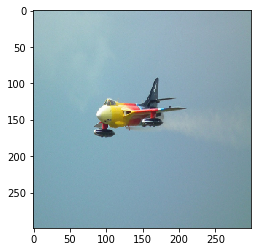

In [77]:
plt.imshow((X[1]))

In [68]:
### loading the model
inception_model = inception_v3.InceptionV3(weights="imagenet", include_top=True)

In [69]:
X[0].dtype

dtype('float64')

In [222]:
preds = inception_model.predict(np.expand_dims(X[1],axis=0))

In [224]:
# wrong usage as imresize scales down imgs
# preds = inception_model.predict(np.expand_dims((X[1] / 2 + 0.5)*255,axis=0))

In [ ]:
for x in decode_predictions(preds)[0]:
    print(x)

In [131]:
# ## to convert from imagenet ids to labels
# imageNet_id2label_file = 'imagenet1000_clsidx_to_labels.json'
# import json
# with open(imageNet_id2label_file,'r') as f:
#     string = f.read().replace('\n','')
# id_label = eval(string)
# id_label[404]

'airliner'

In [80]:
import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [ ]:
# %time explanation = explainer.explain_instance(X[0], inception_model.predict, top_labels=5, num_features=100000, hide_color=0, num_samples=1000)

In [260]:
# explanation.top_labels

[404, 895, 908, 403, 113]

In [261]:
# plt.imshow(explanation.segments)
# explanation.local_exp[404]
# explanation.local_pred

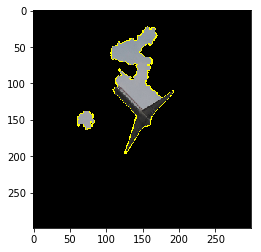

In [229]:
# from skimage.segmentation import mark_boundaries

# img, msk = explanation.get_image_and_mask(explanation.top_labels[2], positive_only=True,
#                                           num_features=5, hide_rest=True)
# plt.imshow(mark_boundaries(img, msk))

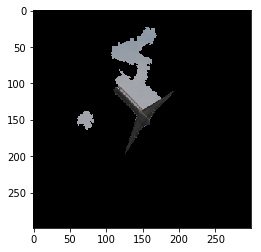

In [230]:
# plt.imshow(img)

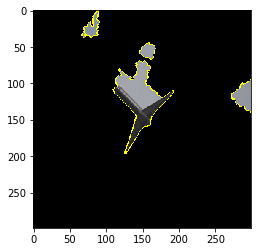

In [247]:
# from lime.wrappers.scikit_image import SegmentationAlgorithm
# random_seed = 1
# segmenter = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200,
#                                   ratio=0.2, random_seed=random_seed)
# explanation2 = explainer.explain_instance(X[0], inception_model.predict, top_labels=5,
#                                          hide_color=0, num_samples=1000,
#                                          segmentation_fn = segmenter)

# img, msk = explanation2.get_image_and_mask(explanation.top_labels[2], positive_only=True,
#                                           num_features=5, hide_rest=True)
# plt.imshow(mark_boundaries(img, msk))

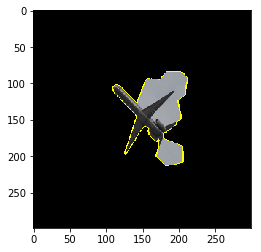

In [248]:
# from lime.wrappers.scikit_image import SegmentationAlgorithm
# random_seed = 1
# segmenter = SegmentationAlgorithm('slic', kernel_size=4, max_dist=200,
#                                   ratio=0.2, random_seed=random_seed)
# explanation2 = explainer.explain_instance(X[0], inception_model.predict, top_labels=5,
#                                          hide_color=0, num_samples=1000,
#                                          segmentation_fn = segmenter)

# img, msk = explanation2.get_image_and_mask(explanation.top_labels[2], positive_only=True,
#                                           num_features=5, hide_rest=True)
# plt.imshow(mark_boundaries(img, msk))

In [291]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
random_seed = 1
segmenter = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200,
                                  ratio=0.2, random_seed=random_seed)

budget = 50
no_superpixels = 5
def bulk_exp(explainer, images):
    return [explainer.explain_instance(image, inception_model.predict, top_labels=5,
                                        num_features=budget, hide_color=0, num_samples=1000,
                                        segmentation_fn = segmenter)   for image in images]

def get_imgs_from_exps(exps):
    return np.array([exp.get_image_and_mask(exp.top_labels[0], positive_only=True,
                                            num_features=no_superpixels, hide_rest=True)[0] for exp in exps])

In [298]:
def calc_identity(img1, img2, verbose=True):
    dis = np.array([np.array_equal(img1[i],img2[i]) for i in range(len(img1))])
    total = dis.shape[0]
    true = np.sum(dis)
    score = (total-true)/total
    if verbose:
        print('true: ',true, 'wrong: ', total-true, 'total: ', total)
    return score*100, true, total

def calc_separability(exp):
    wrong = 0
    for i in range(exp.shape[0]):
        for j in range(exp.shape[0]):
            if i == j:
                continue
            eq = np.array_equal(exp[i],exp[j])
            if eq:
                wrong = wrong + 1
    total = exp.shape[0]
    score = 100*abs(wrong)/(total**2-total)
    print('true: ', total**2-total-wrong, 'wrong: ', wrong, 'total: ', total**2-total)
    return wrong,total,total**2-total,score

In [293]:
%time exps1 = bulk_exp(explainer, X)
%time exps2 = bulk_exp(explainer, X)

CPU times: user 5d 3h 20min 38s, sys: 20h 34min 13s, total: 5d 23h 54min 52s
Wall time: 4h 50min 7s
CPU times: user 5d 4h 52min 59s, sys: 21h 18min 27s, total: 6d 2h 11min 26s
Wall time: 4h 54min 31s


In [296]:
import pickle
with open('exp1.pkl', 'wb') as f:
    pickle.dump(exps1, f)
with open('exp2.pkl', 'wb') as f:
    pickle.dump(exps2, f)

In [294]:
%time imgs1 = get_imgs_from_exps(exps1)
%time imgs2 = get_imgs_from_exps(exps2)

CPU times: user 24.3 s, sys: 7.02 s, total: 31.3 s
Wall time: 4.7 s
CPU times: user 17.2 s, sys: 9.1 s, total: 26.3 s
Wall time: 4.38 s


In [302]:
calc_identity(imgs1,imgs2)

true:  103 wrong:  355 total:  458


(77.51091703056768, 103, 458)

In [301]:
calc_separability(imgs1)

true:  209304 wrong:  2 total:  209306


(2, 458, 209306, 0.0009555387805414082)